# Iinit

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from tqdm.notebook import tqdm
from tqdm import tqdm as tqdm_t

import numpy as onp
import matplotlib.pyplot as plt # visualization

import jax
from jax import ops
import jax.numpy as np
from jax import jit, grad, value_and_grad, random, device_put
from jax import lax
from jax.random import split
from jax.tree_util import tree_multimap
from jax import vmap
from jax.tree_util import Partial as partial

from jax.experimental import optix
from jax.experimental import optimizers
from jax.experimental import stax # neural network library
from jax.experimental.stax import Conv, Dense, MaxPool, Relu, Flatten, LogSoftmax # neural network layers

rng = random.PRNGKey(0)
rng

In [3]:
rng = random.PRNGKey(0)
rng

DeviceArray([0, 0], dtype=uint32)

In [4]:
def sample_tasks(rng, outer_batch_size, inner_batch_size):
    # Select amplitude and phase for the task
    rng, rngA, rngP = split(rng, 3)
    As = random.uniform(rngA, shape=(outer_batch_size,), minval=0.1, maxval=5.0)
    phases = random.uniform(rngP, shape=(outer_batch_size,), minval=0, maxval=np.pi)
    
    def get_batch(rng):
        xs = np.empty((outer_batch_size, inner_batch_size, 1))
        ys = np.empty((outer_batch_size, inner_batch_size, 1))
        rngs = split(rng, outer_batch_size)
        for i, (A, phase, rng) in enumerate(zip(As, phases, rngs)):
            x = random.uniform(rng, shape=(inner_batch_size, 1), minval=-5., maxval=5., )
            y = A * np.sin(x + phase)
            xs = ops.index_update(xs, i, x)
            ys = ops.index_update(ys, i, y)
        return xs, ys
    rng2, rng3 = split(rng, 2)
    x1, y1 = get_batch(rng2)
    x2, y2 = get_batch(rng3)
    return x1, y1, x2, y2, As, phases

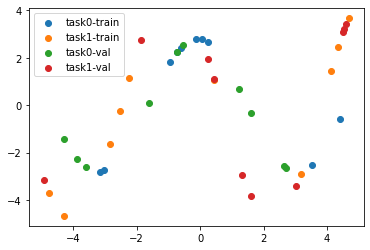

In [5]:
rng, rng_sample = split(rng, 2)
x1, y1, x2, y2, As, phases = sample_tasks(rng, 2, 10)

for i in range(x1.shape[0]):
    plt.scatter(x1[i], y1[i], label='task{}-train'.format(i))
for i in range(x1.shape[0]):
    plt.scatter(x2[i], y2[i], label='task{}-val'.format(i))
plt.legend()

In [6]:
net_init, net_apply = stax.serial(
    Dense(40), Relu,
    Dense(40), Relu,
    Dense(1),
)

def make_net(rng, in_shape=(-1, 1)):
    rng, rng_net = split(rng, 2)
    return net_init(rng_net, in_shape)

def mse_loss(preds, targets):
    return np.mean((preds - targets) ** 2)

In [7]:
xrange_inputs = np.linspace(-5, 5, 100).reshape((100, 1)) # (k, 1)
targets = np.sin(xrange_inputs)

# Train vanilla SGD

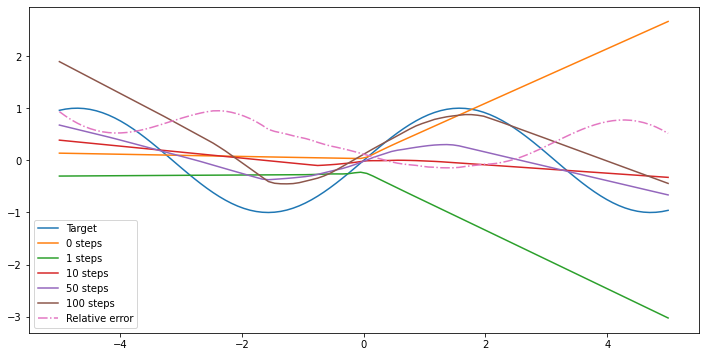

In [8]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(xrange_inputs, targets, label="Target")

out_shape, net_params = make_net(rng)
opt_init, opt_update, get_params = optimizers.sgd(1e-1)
opt_state = opt_init(net_params)

@jit
def loss_fn(params, inputs, targets):
    return mse_loss(net_apply(params, inputs), targets)

ax.plot(xrange_inputs, net_apply(net_params, xrange_inputs), label="0 steps")
plot_steps = [1, 10, 50, 100]
for i in range(1, 101):
    loss, grads = value_and_grad(loss_fn)(net_params, xrange_inputs, targets)
    opt_state = opt_update(i - 1, grads, opt_state)
    net_params = get_params(opt_state)
    
    if i in plot_steps:
        preds = net_apply(net_params, xrange_inputs)
        ax.plot(xrange_inputs, preds, label="%d steps" % i)

pointwise_loss = (preds - targets)
ax.plot(xrange_inputs, pointwise_loss, linestyle='-.', label="Relative error")
ax.legend()

In [9]:
def sgd_k_steps(params, loss_fn, x, y, k, opt_state, opt_get_updates_fn):
    loss_history = np.zeros(k + 1)
    for i in range(k):
        loss, grads = value_and_grad(loss_fn)(params, x, y)
        updates, opt_state = opt_get_updates_fn(grads, opt_state, params)
        params = optix.apply_updates(params, updates)
        loss_history = ops.index_update(loss_history, i, loss)

    final_loss = loss_fn(params, x, y)
    loss_history = ops.index_update(loss_history, k + 1, final_loss)
    
    return params, opt_state, loss_history

def outer_loss_fn(params, inner_loss_fn, x_in, y_in, x_out, y_out, k, inner_opt):
    inner_opt_state = inner_opt.init(params)
    params, _, inner_loss = sgd_k_steps(params, inner_loss_fn, x_in, y_in, k, inner_opt_state, inner_opt.update)
    return mse_loss(net_apply(params, x_out), y_out), inner_loss

def batch_outer_loss(params, inner_loss_fn, x_in, y_in, x_out, y_out, k, inner_opt):
    outer_losses, inner_losses = vmap(
        partial(outer_loss_fn, params, inner_loss_fn, k=k, inner_opt=inner_opt)
    )(x_in, y_in, x_out, y_out)
    return outer_losses.mean(), inner_losses.mean(0)

In [10]:
jit_batch_outer_loss = jit(batch_outer_loss, static_argnums=(1, 6, 7))
jit_sample_tasks = jit(sample_tasks, static_argnums=(1, 2))

In [11]:
inner_opt = optix.sgd(1e-3)
outer_opt_init, outer_opt_update, outer_get_params = optimizers.adam(step_size=1e-3)
out_shape, net_params = make_net(rng)
outer_opt_state = outer_opt_init(net_params)

num_inner_steps = 1
num_tasks = 25
num_samples = 10

@jit
def inner_loss_fn(params, inputs, targets):
    return mse_loss(net_apply(params, inputs), targets)

def step(rng_task, i, opt_state):
    x1, y1, x2, y2, _, _ = jit_sample_tasks(rng_task, num_tasks, num_samples)
    p = outer_get_params(opt_state)
    (outer_loss, inner_loss), outer_grads = value_and_grad(
        jit_batch_outer_loss, has_aux=True,
    )(p, inner_loss_fn, x1, y1, x2, y2, num_inner_steps, inner_opt)
    opt_state = outer_opt_update(i, outer_grads, opt_state)
    net_params = outer_get_params(opt_state)
    
    return opt_state, outer_loss, inner_loss

device = "gpu"
backend = jax.devices(device)[0]
step = jit(step, backend=device)

num_outer_steps = 70000
pbar = tqdm_t(range(num_outer_steps))
# np_batched_maml_loss = []
np_batched_maml_loss = device_put(np.zeros(num_outer_steps), backend)
for i in pbar:
    rng, rng_task = split(rng, 2)
    outer_opt_state, outer_loss, inner_loss = step(rng_task, i, outer_opt_state)

    if (i % 500) == 0:
        pbar.set_postfix(
            outer_loss=outer_loss, inner_loss=inner_loss[-1],
            refresh=True,
        )
    # np_batched_maml_loss.append(outer_loss)
    np_batched_maml_loss = ops.index_update(np_batched_maml_loss, i, outer_loss)
    
multi_batch_params = outer_get_params(outer_opt_state)

100%|██████████| 70000/70000 [06:22<00:00, 182.89it/s, inner_loss=0.0, outer_loss=0.14124174]


MSE 5-shot 1 steps
0.5588433
MSE 5-shot 5 steps
0.4542633
MSE 5-shot 10 steps
0.46389723


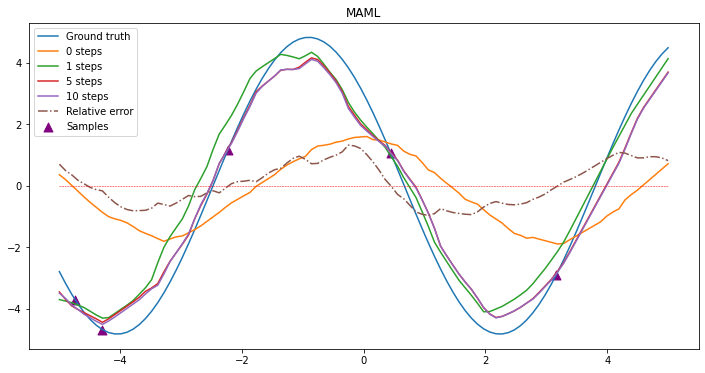

In [12]:
num_samples = 5

np_batched_maml_lfig, ax = plt.subplots(figsize=(12, 6))
ax.plot(xrange_inputs, np.sin(xrange_inputs + phases[1]) * As[1], label="Ground truth")
ax.scatter(x1[1, :5], y1[1, :5], marker="^", label="Samples", color="purple", s=80)

new_params = multi_batch_params
ax.plot(xrange_inputs, net_apply(new_params, xrange_inputs), label="0 steps")
inner_opt = optix.sgd(1e-3)
inner_opt_state = inner_opt.init(new_params)
for i in range(0, 10):
    new_params, inner_opt_state, loss = sgd_k_steps(
        new_params, inner_loss_fn, x1[1, :num_samples], y1[1, :num_samples], 1, inner_opt_state, inner_opt.update,
        )

    # (new_params, inner_opt_state), loss = jittable_k_updates(
    #     new_params, x1[1, :5], y1[1, :5], k=1, opt_state=inner_opt_state, opt_update=inner_opt.update,
    # )

    if (i + 1) in [1, 5, 10]:
        preds = net_apply(new_params, xrange_inputs)
        ax.plot(xrange_inputs, preds, label="%d steps" % (i + 1))

        pointwise_loss = (np.sin(xrange_inputs + phases[1]) * As[1] - preds)
        print("MSE 5-shot %d steps" % (i + 1))
        print((pointwise_loss ** 2).mean())
        
ax.plot(xrange_inputs, pointwise_loss, linestyle='-.', label="Relative error")
ax.plot(xrange_inputs, np.zeros(len(xrange_inputs)), color="red", linestyle='--', linewidth=0.5)


ax.legend()
ax.set_title("MAML");

# Continul Learning

In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from tqdm.notebook import tqdm
from tqdm import tqdm as tqdm_t

import numpy as onp
import matplotlib.pyplot as plt # visualization

import jax
from jax import ops
import jax.numpy as np
from jax import jit, grad, value_and_grad, random, device_put
from jax import lax
from jax.random import split
from jax.tree_util import tree_multimap
from jax import vmap
from jax.tree_util import Partial as partial

from jax.experimental import optix
from jax.experimental import optimizers
from jax.experimental import stax # neural network library
from jax.experimental.stax import Conv, Dense, MaxPool, Relu, Flatten, LogSoftmax # neural network layers

rng = random.PRNGKey(0)
rng

DeviceArray([0, 0], dtype=uint32)

In [34]:
class SineSampler:
    def __init__(self, rng, tasks, capacity):
        self.tasks = tasks
        self.capacity = capacity
        self.task_iterators = []

        rng_amplitude, rng_phase, rng_decay, rng_frequency = split(rng, 4)

        self.iterators = {
            "id": tasks,
            "amplitude": random.uniform(rng_amplitude, (len(tasks),), minval=0.1, maxval=5.0),
            "phase": random.uniform(rng_amplitude, (len(tasks),), minval=0.0, maxval=1.0) * np.pi,
            "decay": random.uniform(rng_decay, (len(tasks),), minval=0.0, maxval=1.0) * 0.4,
            "frequency": random.uniform(rng_frequency, (len(tasks),), minval=0.0, maxval=1.0) * 2 + 1.0,
        }

    def get_task(self, task):
        return {
            "id": self.iterators["id"][task],
            "amplitude": self.iterators["amplitude"][task],
            "phase": self.iterators["phase"][task],
            "decay": self.iterators["decay"][task],
            "frequency": self.iterators["frequency"][task],
        }

    def sample_batch(self, rng, task, task_map_id, num_samples=10):
        rng, rng_samples = split(rng, 2)
        x_samples = random.uniform(rng_samples, (num_samples,), minval=-5.0, maxval=5.0)
        x = np.zeros((num_samples, self.capacity))
        x = ops.index_update(x, ops.index[:, self.capacity - 1], x_samples)
        # assert task_map_id < self.capacity
        # assert lax.lt(task_map_id, self.capacity)
        x = ops.index_update(x, ops.index[:, task_map_id], 1)

        targets = np.zeros((num_samples, 2))
        amplitude = self.iterators["amplitude"][task]
        phase = self.iterators["phase"][task]
        targets = ops.index_update(targets, ops.index[:, 0], amplitude * np.sin(x_samples + phase))

        return None, x, targets

In [299]:
def make_sine_sampler(rng, tasks, capacity):
    tasks = tasks
    capacity = capacity

    rng_amplitude, rng_phase, rng_decay, rng_frequency = split(rng, 4)
    amplitudes = random.uniform(rng_amplitude, (len(tasks),), minval=0.1, maxval=5.0)
    phases = random.uniform(rng_amplitude, (len(tasks),), minval=0.0, maxval=1.0) * np.pi
    decays = random.uniform(rng_decay, (len(tasks),), minval=0.0, maxval=1.0) * 0.4
    frequency = random.uniform(rng_frequency, (len(tasks),), minval=0.0, maxval=1.0) * 2 + 1.0
    
    def sample_batch(rng, task, task_map_id, num_samples):
        rng, rng_samples = split(rng, 2)
        x_samples = random.uniform(rng_samples, (num_samples,), minval=-5.0, maxval=5.0)
        x = np.zeros((num_samples, capacity))
        x = ops.index_update(x, ops.index[:, capacity - 1], x_samples)
        # assert task_map_id < capacity
        # assert lax.lt(task_map_id, capacity - 1)
        x = ops.index_update(x, ops.index[:, task_map_id], 1)

        targets = np.zeros((num_samples, 2))
        amplitude = amplitudes[task]
        phase = phases[task]
        targets = ops.index_update(targets, ops.index[:, 0], amplitude * np.sin(x_samples + phase))

        return x, targets, amplitude, phase

    return sample_batch

In [300]:
tasks = list(range(400))
sample_sine_batch = jit(make_sine_sampler(rng, tasks, 51), static_argnums=(3,))
x, y, amplitudes, phases = sample_sine_batch(rng, 12, 0, 10)

In [326]:
def make_construct_sets(
    sampler, capacity, num_tasks, num_batches_per_task, num_samples_per_batch, shuffle_ids=True,
):
    all_ids = np.arange(capacity - 1)
    train_sampler = partial(sampler, num_samples=num_batches_per_task * num_samples_per_batch)
    test_sampler = partial(sampler, num_samples=num_samples_per_batch)
    def construct_sets(rng, tasks):
        rng, rng_shuffle, rng_train, rng_test = split(rng, 4)
        
        if shuffle_ids:
            id_map = random.choice(rng_shuffle, all_ids, (num_tasks,), replace=False)
        else:
            id_map = np.arange(0, num_tasks)
        
        x_spt, y_spt, amplitudes, phases = vmap(train_sampler)(split(rng_train, num_tasks), tasks, id_map)
        x_qry, y_qry, _, _ = vmap(test_sampler)(split(rng_test, num_tasks), tasks, id_map)
        
        return (
            x_spt.reshape(num_tasks, num_batches_per_task, num_samples_per_batch, -1), 
            y_spt.reshape(num_tasks, num_batches_per_task, num_samples_per_batch, -1),
            x_qry.reshape(num_tasks * num_samples_per_batch, -1),
            y_qry.reshape(num_tasks * num_samples_per_batch, -1),
            id_map,
            amplitudes,
            phases
        )
        
    return construct_sets

In [329]:
capacity = 51
num_batches_per_task = 40
num_samples_per_batch = 10
num_samples = num_batches_per_task * num_samples_per_batch
num_all_tasks = 400
tasks = list(range(num_all_tasks))
sample_sine_batch = make_sine_sampler(rng, tasks, capacity)

num_tasks_per_step = 10
construct_sets = jit(make_construct_sets(
    sample_sine_batch,
    capacity=capacity,
    num_tasks=num_tasks_per_step,
    num_batches_per_task=num_batches_per_task,
    num_samples_per_batch=num_samples_per_batch,
    
))
out = construct_sets(rng, random.choice(rng, tasks, shape=(num_tasks_per_step,), replace=False))

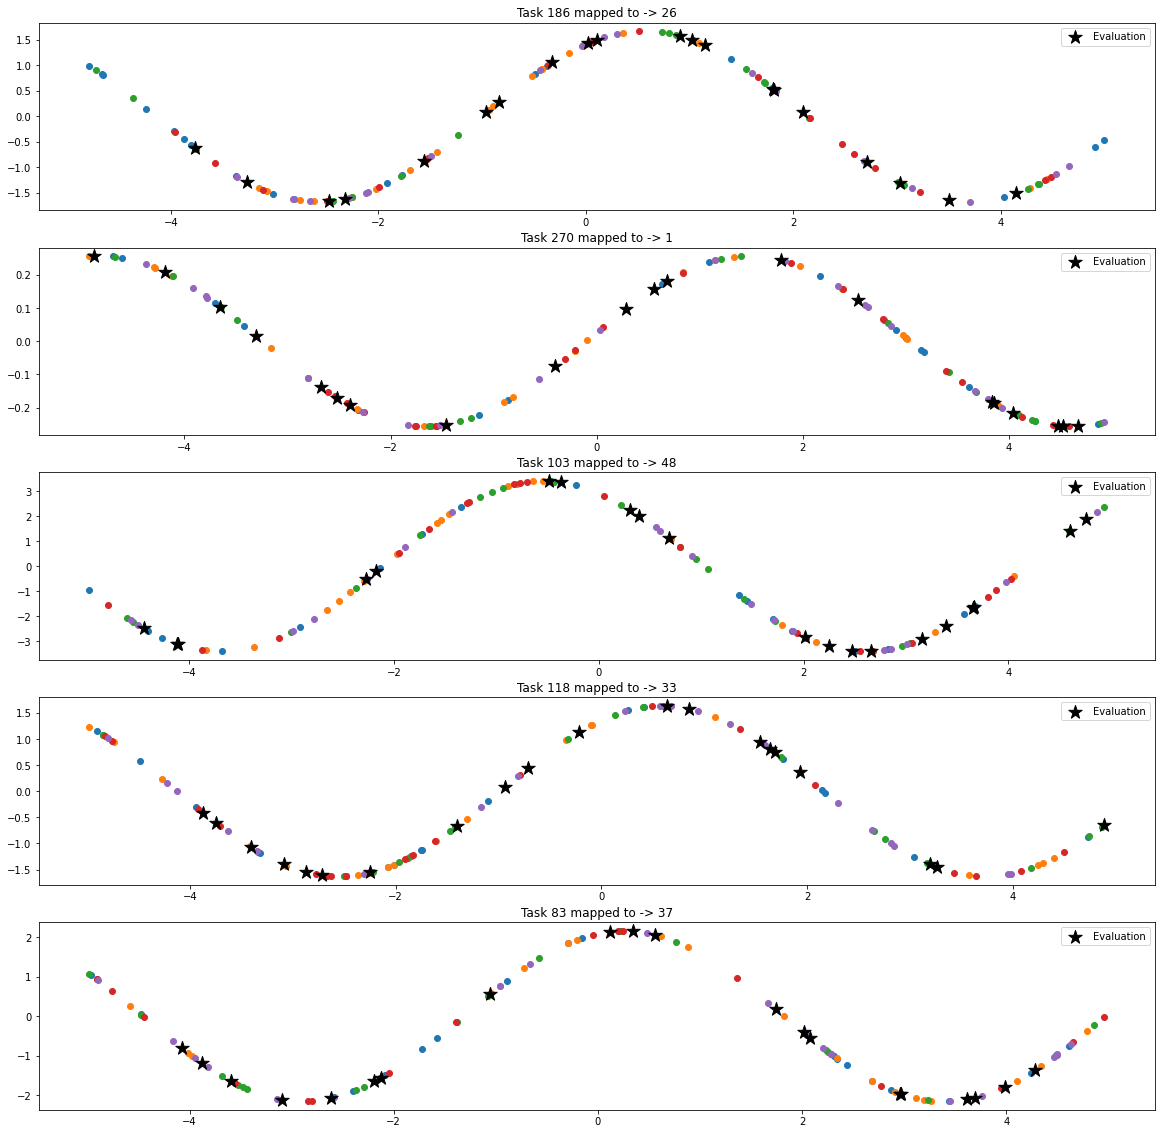

In [334]:
num_tasks = 5
num_steps = 5
num_samples = 20

construct_sets = jit(make_construct_sets(
    sample_sine_batch,
    capacity=capacity,
    num_tasks=num_tasks,
    num_batches_per_task=num_steps,
    num_samples_per_batch=num_samples,
))
# out = construct_sets(rng, random.choice(rng, tasks, shape=(num_tasks_per_step,), replace=False))

sampled_tasks = random.choice(rng, tasks, shape=(num_tasks,), replace=False)
x_spt, y_spt, x_qry, y_qry, mapped_ids, _, _ = construct_sets(rng, sampled_tasks)

fig, axes = plt.subplots(ncols=1, nrows=num_tasks, figsize=(20, 20))

_x_qry = x_qry.reshape(num_tasks, num_samples, -1)
_y_qry = y_qry.reshape(num_tasks, num_samples, -1)

for task_num in range(num_tasks):
    ax = axes[task_num]
    task_id = sampled_tasks[task_num]
    for step_num in range(num_steps):
        x = x_spt[task_num, step_num]
        y = y_spt[task_num, step_num]
        
        mapped_id = x[:, :-1].nonzero()[1]
        assert (mapped_id[0] == mapped_id).all()
        mapped_id = mapped_id[0]
        
        ax.scatter(x[:, -1], y[:, 0])
        
    x = _x_qry[task_num]
    y = _y_qry[task_num]
    
    qry_mapped_id = x[:, :-1].nonzero()[1]
    assert (qry_mapped_id[0] == qry_mapped_id).all()
    qry_mapped_id = qry_mapped_id[0]
    assert qry_mapped_id == mapped_id
    
    ax.scatter(x[:, -1], y[:, 0], marker="*", s=200, c="black", label="Evaluation")
    
    ax.set_title("Task %d mapped to -> %d" % (task_id, mapped_id))
    ax.legend()

In [252]:
from jax import nn as nn

In [282]:
hidden_dim = 400
num_rln_layers = 6
num_pln_layers = 2

rln_init, rln_apply = stax.serial(
    *([stax.Dense(hidden_dim, W_init=nn.initializers.he_normal(), b_init=nn.initializers.zeros), stax.Relu] * num_rln_layers),
)

pln_init, pln_apply = stax.serial(
    *([stax.Dense(hidden_dim, W_init=nn.initializers.he_normal(), b_init=nn.initializers.zeros), stax.Relu] * num_pln_layers),
    stax.Dense(2, W_init=nn.initializers.he_normal(), b_init=nn.initializers.zeros),
)

def cl_net_init(rng, input_shape):
    rng_rln, rng_pln = split(rng, 2)
    rln_out_shape, rln_params = rln_init(rng_rln, input_shape)
    pln_out_shape, pln_params = pln_init(rng_pln, rln_out_shape)
    return rln_params, pln_params

@jit
def cl_net_apply(rln_params, pln_params, inputs):
    return pln_apply(pln_params, rln_apply(rln_params, inputs))

In [159]:
@jit
def mse_loss(preds, targets):
    return np.mean((preds - targets) ** 2)

@jit
def cl_net_mse_loss(rln_params, pln_params, inputs, targets):
    return mse_loss(cl_net_apply(rln_params, pln_params, inputs), targets)

In [244]:
def make_inner_loop(opt_update_fn):
    def inner_loop(rln_params, pln_params, x_spt, y_spt, opt_state):
        for _x, _y in zip(x_spt, y_spt):
            loss, grads = value_and_grad(cl_net_mse_loss, 1)(rln_params, pln_params, _x, _y)
            updates, opt_state = opt_update_fn(grads, opt_state, pln_params)
            pln_params = optix.apply_updates(pln_params, updates)
        return pln_params, loss, opt_state
    
    return inner_loop

In [184]:
def make_outer_loop_loss_fn(inner_opt_init, inner_loop):
    def outer_loss_fn(rln_params, pln_params, x_spt, y_spt, x_qry, y_qry):
        inner_opt_state = inner_opt_init(pln_params)
        pln_params, _, _ = inner_loop(
            rln_params, pln_params, x_spt, y_spt, inner_opt_state,
        )
        return cl_net_mse_loss(rln_params, pln_params, x_qry, y_qry)
    return outer_loss_fn

In [195]:
def make_outer_loop_grads_fn(outer_loop_fn):
    def outer_loop_grads(rln_params, pln_params, x_spt, y_spt, x_qry, y_qry):
        return value_and_grad(outer_loop_fn, argnums=(0, 1))(rln_params, pln_params, x_spt, y_spt, x_qry, y_qry)
    return outer_loop_grads

In [336]:
def make_step_fn(tasks, num_tasks, construct_sets_fn, outer_loop_grads_fn, opt_update, opt_get_params):
    def step(rng, i, opt_state):
        rng_samples, rng_tasks = split(rng, 2)
        sampled_tasks = random.choice(rng_tasks, tasks, shape=(num_tasks,), replace=False)
        x_spt, y_spt, x_qry, y_qry, _, _, _ = construct_sets_fn(rng_samples, sampled_tasks)
        
        rln_params, pln_params = opt_get_params(opt_state)
        outer_loss, outer_grads = outer_loop_grads_fn(rln_params, pln_params, x_spt, y_spt, x_qry, y_qry)
        # outer_loss, outer_grads = value_and_grad(outer_loop_fn, argnums=(0, 1))(rln_params, pln_params, x_spt, y_spt, x_qry, y_qry)
        opt_state = opt_update(i, outer_grads, opt_state)
        
        return opt_state, outer_loss
    return step

In [276]:
capacity = 51
num_all_tasks = 400
tasks = list(range(num_tasks))
sample_sine_batch = make_sine_sampler(rng, tasks, capacity)

rln_params, pln_params = cl_net_init(rng, (-1, capacity))
cl_net_apply(rln_params, pln_params, np.zeros((10, 51)));

cl_net_mse_loss(rln_params, pln_params, np.zeros((10, 51)), np.zeros((10, 2)));

In [277]:
num_tasks = 10
num_steps = 40
num_samples = 10

construct_sets = jit(make_construct_sets(
    sample_sine_batch,
    capacity=capacity,
    num_tasks=num_tasks,
    num_batches_per_task=num_steps,
    num_samples_per_batch=num_samples,
))

sampled_tasks = random.choice(rng, tasks, shape=(num_tasks,), replace=False)
x_spt, y_spt, x_qry, y_qry = construct_sets(rng, sampled_tasks)

In [283]:
rln_params, pln_params = cl_net_init(rng, (-1, capacity))
inner_opt = optix.chain(optix.clip(10), optix.sgd(3e-3))
inner_opt_state = inner_opt.init(pln_params)

inner_loop = jit(make_inner_loop(inner_opt.update))
final_pln_params, _, _ = inner_loop(rln_params, pln_params, x_spt, y_spt, inner_opt_state);

In [291]:
outer_loop = jit(make_outer_loop_loss_fn(inner_opt.init, inner_loop))
outer_loop(rln_params, pln_params, x_spt, y_spt, x_qry, y_qry);

In [292]:
outer_loop_grads = jit(make_outer_loop_grads_fn(outer_loop))
outer_loss, outer_grads = outer_loop_grads(rln_params, pln_params, x_spt, y_spt, x_qry, y_qry);

In [224]:
rng, rng_net, rng_sampler_init = split(rng, 3)

In [293]:
rln_params, pln_params = cl_net_init(rng_net, (-1, capacity))

outer_opt_init, outer_opt_update, outer_get_params = optimizers.adam(step_size=1e-4)
outer_opt_state = outer_opt_init((rln_params, pln_params))

step_fn = jit(make_step_fn(tasks, num_tasks, construct_sets, outer_loop_grads, outer_opt_update, outer_get_params))

num_outer_steps = 20000
pbar = tqdm(range(num_outer_steps))
oml_loss = device_put(np.zeros(num_outer_steps))
for i in pbar:
    rng, rng_task = split(rng, 2)
    outer_opt_state, outer_loss = step_fn(rng_task, i, outer_opt_state)

    if (i % 50) == 0:
        pbar.set_postfix(
            outer_loss=outer_loss,
            refresh=True,
        )
    oml_loss = ops.index_update(oml_loss, i, outer_loss)
    
oml_params = outer_get_params(outer_opt_state)

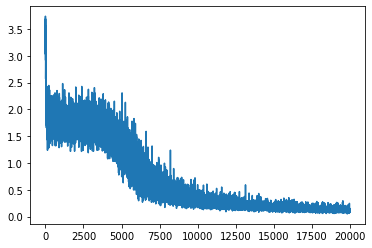

In [294]:
plt.plot(oml_loss)

In [ ]:
def make_construct_sets(
    sampler, capacity, num_tasks, num_batches_per_task, num_samples_per_batch, shuffle_ids=True,
):
    all_ids = np.arange(capacity - 1)
    train_sampler = partial(sampler, num_samples=num_batches_per_task * num_samples_per_batch)
    test_sampler = partial(sampler, num_samples=num_samples_per_batch)
    def construct_sets(rng, tasks):
        rng, rng_shuffle, rng_train, rng_test = split(rng, 4)
        
        if shuffle_ids:
            id_map = random.choice(rng_shuffle, all_ids, (num_tasks,), replace=False)
        else:
            id_map = np.arange(0, num_tasks)
        
        x_spt, y_spt = vmap(train_sampler)(split(rng_train, num_tasks), tasks, id_map)
        x_qry, y_qry = vmap(test_sampler)(split(rng_test, num_tasks), tasks, id_map)
        
        return (
            x_spt.reshape(num_tasks, num_batches_per_task, num_samples_per_batch, -1), 
            y_spt.reshape(num_tasks, num_batches_per_task, num_samples_per_batch, -1),
            x_qry.reshape(num_tasks * num_samples_per_batch, -1),
            y_qry.reshape(num_tasks * num_samples_per_batch, -1),
        )
        
    return construct_sets

In [383]:
rng, rng_sampler, rng_sample, rng_choice = split(rng, 4)

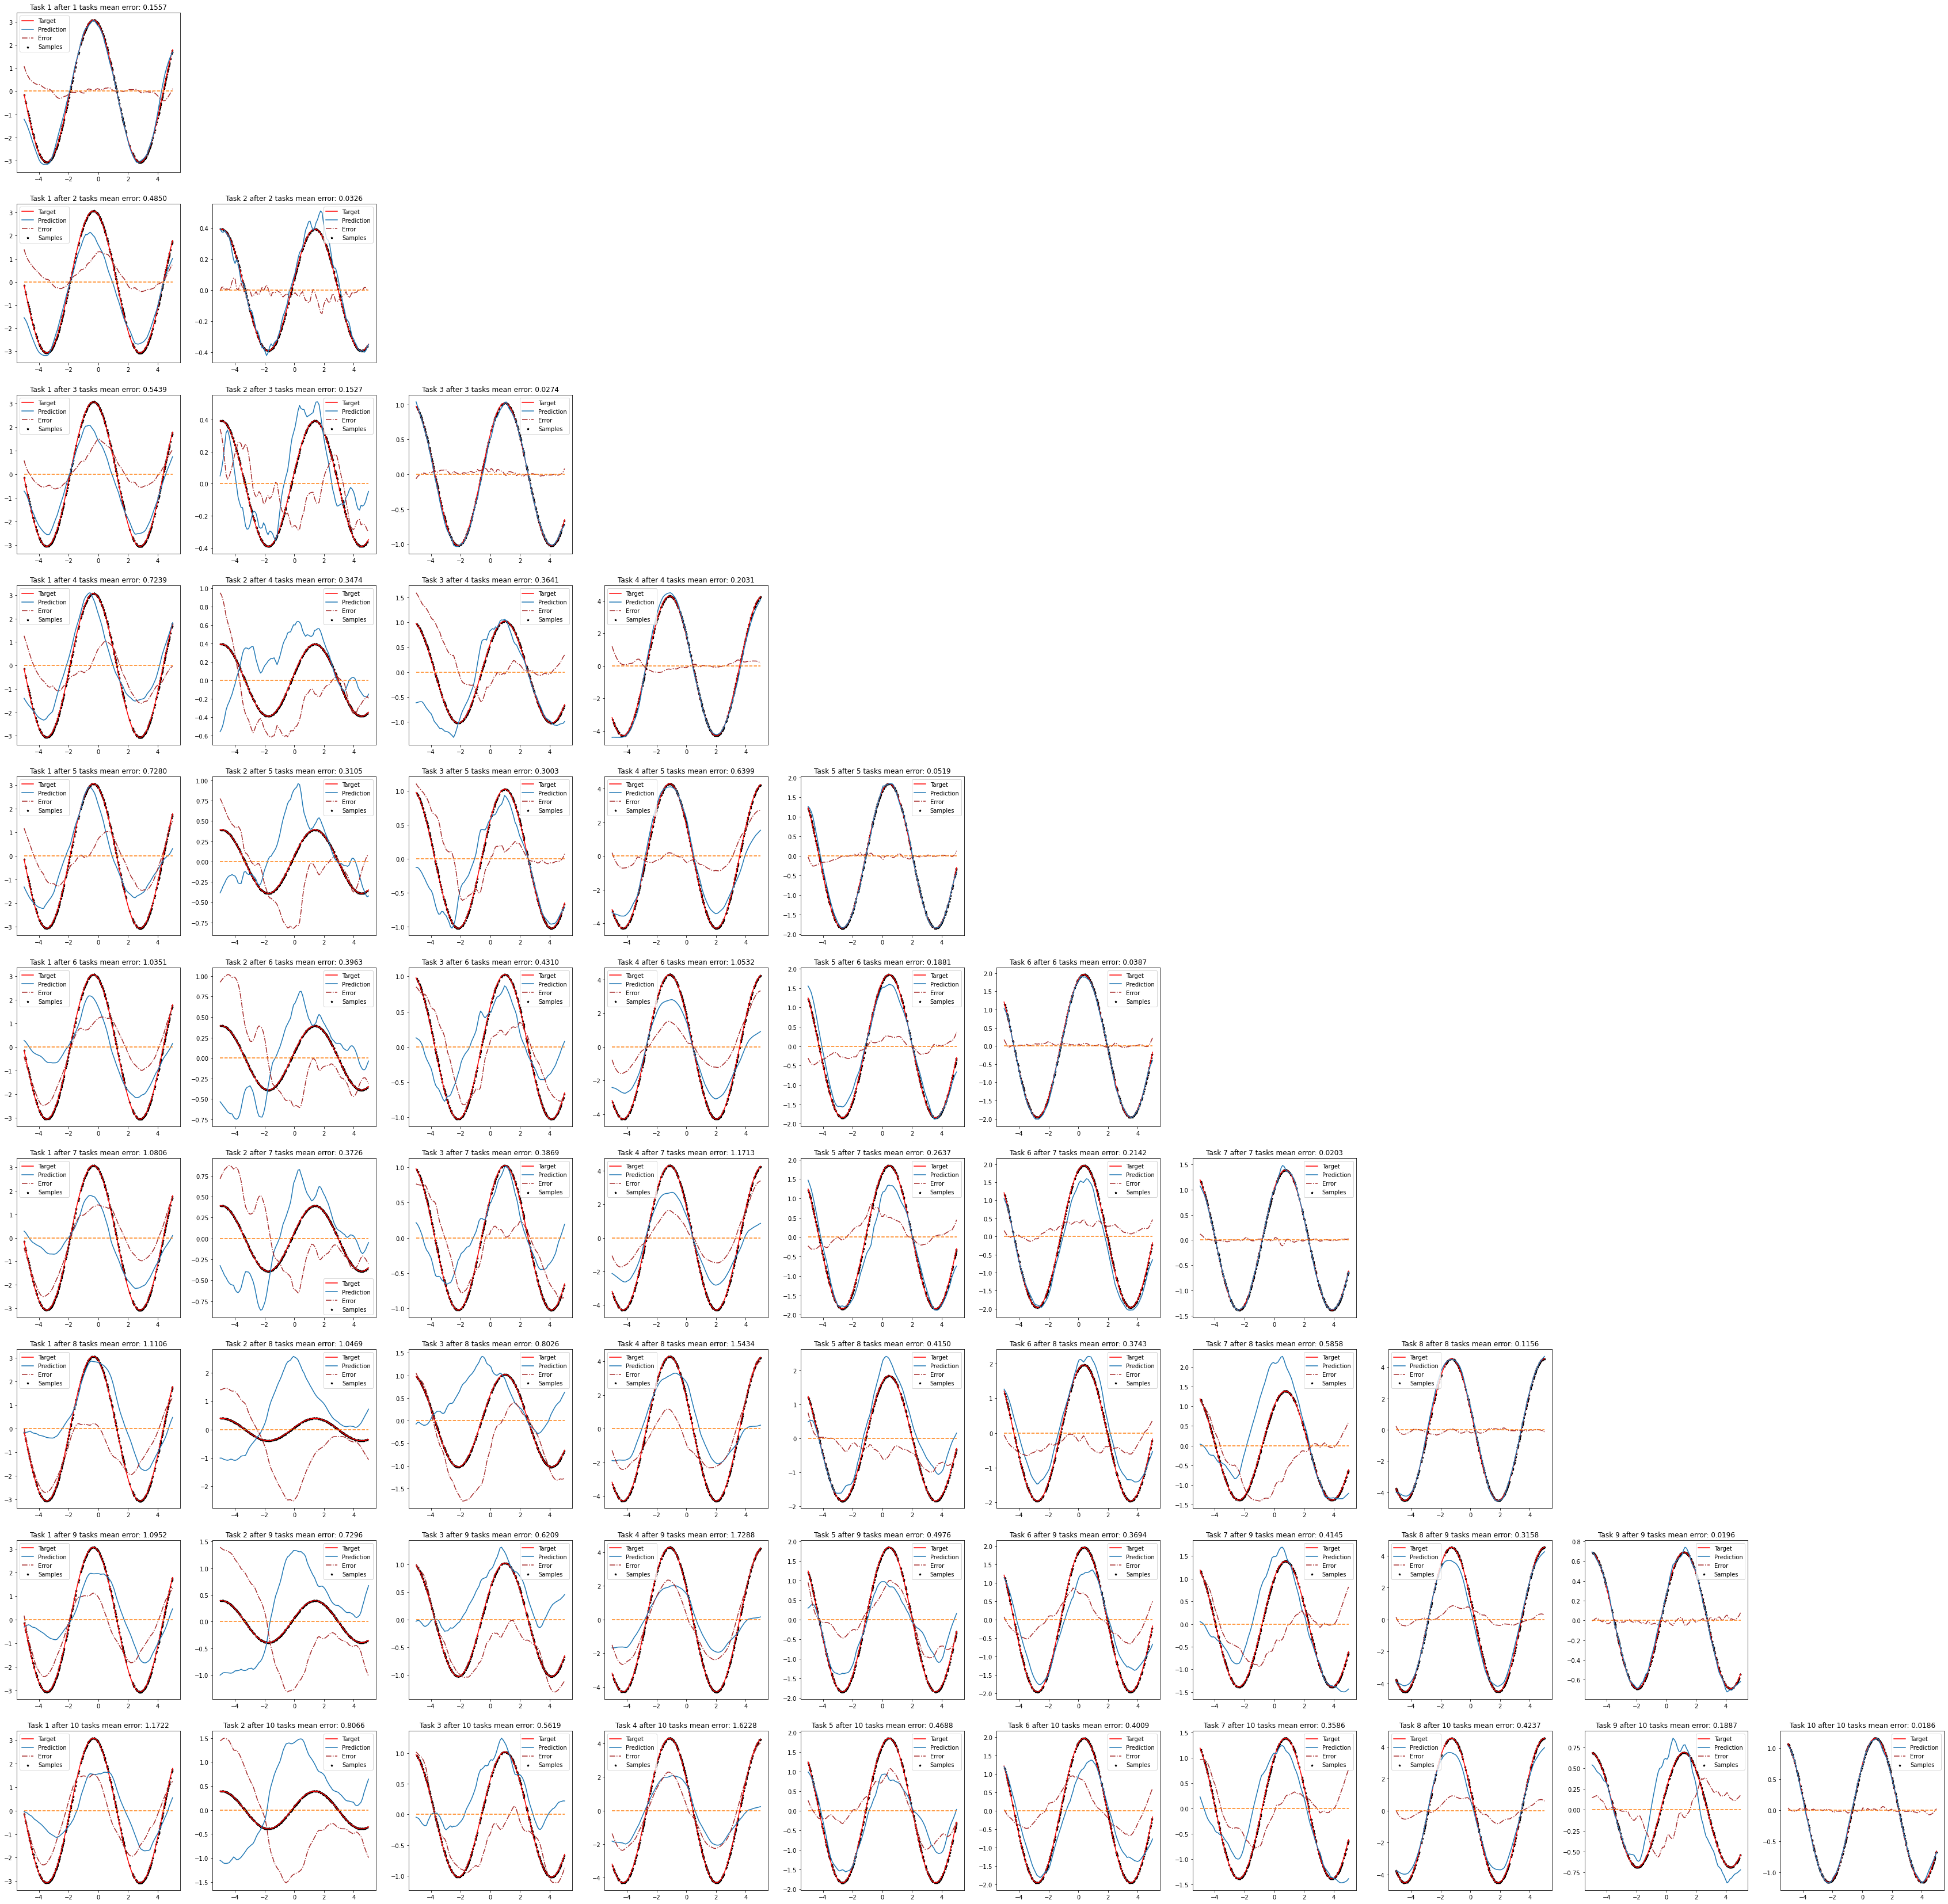

In [412]:
num_test_tasks = 10
test_sine_sampler = make_sine_sampler(rng_sampler, tasks, capacity)
test_construct_sets = make_construct_sets(test_sine_sampler, capacity, num_test_tasks, 40, 10)
x_spt, y_spt, x_qry, y_qry, mapped_ids, amplitudes, phases = test_construct_sets(rng_sample, random.choice(rng_choice, tasks, (num_test_tasks,), replace=False))

inner_opt = optix.chain(optix.clip(10), optix.sgd(3e-3))
fast_pln_params = oml_params[1]
inner_opt_state = inner_opt.init(fast_pln_params)
test_inner_loop = jit(make_inner_loop(inner_opt.update))

xrange_inputs = np.linspace(-5, 5, 100)
xrange_inputs_w_cap = np.zeros((num_test_tasks, 100, 51))
xrange_inputs_w_cap = ops.index_update(xrange_inputs_w_cap, ops.index[:, :, -1], xrange_inputs)
targets = amplitudes.reshape(num_test_tasks, 1) * np.sin(xrange_inputs.reshape(1, 100) + phases.reshape(num_test_tasks, 1))

fig, axes = plt.subplots(ncols=num_test_tasks, nrows=num_test_tasks, figsize=(6 * num_test_tasks, 6 * num_test_tasks))
for ax in axes.flatten():
    ax.set_visible(False)

for task_num in range(num_test_tasks):
        
    for batch_num in range(40):
        
        fast_pln_params, final_loss, inner_opt_state = inner_loop(
            oml_params[0], fast_pln_params, x_spt[task_num, batch_num], y_spt[task_num, batch_num], inner_opt_state,
        )
    
    xrange_inputs_w_cap = ops.index_update(xrange_inputs_w_cap, ops.index[task_num, :, :-1], x_spt[task_num, 0, 0, :-1])
    preds = cl_net_apply(oml_params[0], fast_pln_params, xrange_inputs_w_cap)

    for i in range(task_num + 1):
        row_num = task_num
        col_num = i
        ax = axes[row_num, col_num]
        ax.set_visible(True)
        
        ax.scatter(x_spt[i, :, :, -1].reshape(-1, 1), y_spt[i, :, :, 0].reshape(-1, 1), label="Samples", s=10, c="black", marker="*")
        
        targets = amplitudes[i] * np.sin(xrange_inputs + phases[i])
        ax.plot(xrange_inputs, targets, label="Target", c="red")
        
        ax.plot(xrange_inputs, preds[i, :, 0], label="Prediction")
        
        error = targets - preds[i, :, 0]
        ax.plot(xrange_inputs, error, label="Error", linestyle="-.", c="brown")
        
        ax.plot(xrange_inputs, np.zeros((100)), linestyle="--")
        
        ax.set_title(f"Task {i + 1} after {task_num + 1} tasks mean error: {np.abs(error).mean():.4f}")
        
        ax.legend()

In [406]:
np.abs(error).mean()

DeviceArray(0.03382086, dtype=float32)

In [376]:
y_spt[0, :, :, 0].reshape(-1, 1).shape

(400, 1)

In [370]:
axes

array([[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

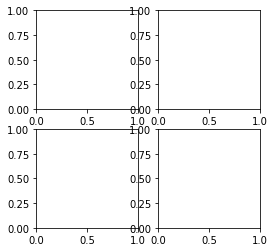

In [364]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(4 * 1, 4 * 1))

In [367]:
axes

array([[<AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>]], dtype=object)

In [362]:
preds.shape

(10, 100, 2)

In [356]:
x_spt[task_num, batch_num][0, :-1].shape

(50,)

In [357]:
ops.index_update(xrange_inputs_w_cap, ops.index[:, :-1], x_spt[task_num, batch_num][0, :-1])

DeviceArray([[ 0.       ,  0.       ,  1.       , ...,  0.       ,
               0.       , -5.       ],
             [ 0.       ,  0.       ,  1.       , ...,  0.       ,
               0.       , -4.8989897],
             [ 0.       ,  0.       ,  1.       , ...,  0.       ,
               0.       , -4.7979794],
             ...,
             [ 0.       ,  0.       ,  1.       , ...,  0.       ,
               0.       ,  4.7979794],
             [ 0.       ,  0.       ,  1.       , ...,  0.       ,
               0.       ,  4.8989897],
             [ 0.       ,  0.       ,  1.       , ...,  0.       ,
               0.       ,  5.       ]], dtype=float32)

In [353]:
xrange_inputs_w_cap[:, :-1].shape

(100, 50)

In [349]:
xrange_inputs_w_cap

DeviceArray([[ 0.       ,  0.       ,  0.       , ...,  0.       ,
               0.       , -5.       ],
             [ 0.       ,  0.       ,  0.       , ...,  0.       ,
               0.       , -4.8989897],
             [ 0.       ,  0.       ,  0.       , ...,  0.       ,
               0.       , -4.7979794],
             ...,
             [ 0.       ,  0.       ,  0.       , ...,  0.       ,
               0.       ,  4.7979794],
             [ 0.       ,  0.       ,  0.       , ...,  0.       ,
               0.       ,  4.8989897],
             [ 0.       ,  0.       ,  0.       , ...,  0.       ,
               0.       ,  5.       ]], dtype=float32)

In [347]:
x_spt[task_num, batch_num, 0, :capacity - 1].shape

(50,)

In [351]:
cl_net_apply(*oml_params, xrange_inputs_w_cap).shape

(100, 2)

In [321]:
xrange_inputs = np.linspace(-5, 5, 100)
targets = amplitudes.reshape(10, 1) * np.sin(xrange_inputs.reshape(1, 100) + phases.reshape(10, 1))

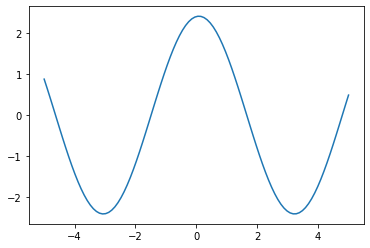

In [322]:
plt.plot(xrange_inputs, targets[0])